In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "../data/processed_data/classification_data.csv"
df = pd.read_csv(file_path)

# Convert transaction descriptions to lowercase for consistency
df["transaction_description"] = df["transaction_description"].str.lower()

# Shuffle dataset to avoid biases
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Ensure unique transaction descriptions per set
unique_descriptions = df["transaction_description"].unique()
train_descriptions = set(np.random.choice(unique_descriptions, size=int(0.75 * len(unique_descriptions)), replace=False))

# Assign train-test sets based on description uniqueness
train_df = df[df["transaction_description"].isin(train_descriptions)]
test_df = df[~df["transaction_description"].isin(train_descriptions)]

# Extract Features & Labels
X_train, y_train = train_df["transaction_description"], train_df["merchant_category_encoded"]
X_test, y_test = test_df["transaction_description"], test_df["merchant_category_encoded"]

# Print results
print(f" New Train-Test Split: Train Size = {X_train.shape[0]}, Test Size = {X_test.shape[0]}")

 New Train-Test Split: Train Size = 122040, Test Size = 27960


In [2]:
# Extract unique transaction descriptions from each set
train_descriptions = set(X_train)
test_descriptions = set(X_test)

# Find overlaps
overlapping_descriptions = train_descriptions.intersection(test_descriptions)

if overlapping_descriptions:
    print(f" WARNING: {len(overlapping_descriptions)} overlapping transactions found! Removing from test set.")

    # Remove overlapping transactions from test set
    test_df = test_df[~test_df["transaction_description"].isin(overlapping_descriptions)]
    X_test, y_test = test_df["transaction_description"], test_df["merchant_category_encoded"]

    print(f" Overlapping transactions removed! New test set size: {X_test.shape[0]}")
else:
    print(" No data leakage detected!")

 No data leakage detected!


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Initialize Tokenizer
MAX_VOCAB_SIZE = 10000  # we can adjust based on data
MAX_SEQUENCE_LENGTH = 50  # Truncate/pad to this length

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Fit only on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Apply Padding (ensure uniform sequence length)
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

# Saving Tokenizer for future inference
with open("../data/models/tokenizer.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

print(" Tokenization & Padding Completed!")

 Tokenization & Padding Completed!


In [5]:
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split

# Count occurrences of each class
class_counts = Counter(y_train)

# Identify classes that have only one instance
single_instance_classes = [cls for cls, count in class_counts.items() if count < 2]
print(f" Classes with less than 2 samples: {single_instance_classes}")

# Filter out these classes
keep_indices = ~np.isin(y_train, single_instance_classes)
X_train_padded_filtered = X_train_padded[keep_indices]
y_train_filtered = y_train[keep_indices]

# Perform the final split with stratification
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_train_padded_filtered, y_train_filtered,
    test_size=0.2, random_state=42, stratify=y_train_filtered
)

print(f" Final Training Data: {X_train_final.shape}, Labels: {y_train_final.shape}")
print(f" Final Testing Data: {X_test_final.shape}, Labels: {y_test_final.shape}")

 Classes with less than 2 samples: [11]
 Final Training Data: (97631, 50), Labels: (97631,)
 Final Testing Data: (24408, 50), Labels: (24408,)


In [6]:
# Check for missing classes
train_classes = set(y_train_final)
test_classes = set(y_test_final)
missing_classes = train_classes - test_classes

print(f"️ Missing classes in test set: {missing_classes}")

# Remove low-frequency classes from training set
keep_indices = ~np.isin(y_train_final, list(missing_classes))
X_train_final = X_train_final[keep_indices]
y_train_final = y_train_final[keep_indices]

print(f" Updated Train Set: {X_train_final.shape}, Labels: {y_train_final.shape}")

️ Missing classes in test set: {24}
 Updated Train Set: (97629, 50), Labels: (97629,)


In [8]:
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Ensure labels are sequential after removing low-sample classes
label_encoder = LabelEncoder()
y_train_final = label_encoder.fit_transform(y_train_filtered)
y_test_final = label_encoder.transform(y_test_final)

# Ensure correct number of classes
num_classes = len(np.unique(y_train_final))

# Convert labels to one-hot encoding
y_train_final = to_categorical(y_train_final, num_classes=num_classes)
y_test_final = to_categorical(y_test_final, num_classes=num_classes)

# Print updated label shapes
print(f"y_train shape: {y_train_final.shape}")
print(f"y_test shape: {y_test_final.shape}")

y_train shape: (122039, 102)
y_test shape: (24408, 102)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),
    LSTM(64, return_sequences=False),
    Dropout(0.5),  # Increased dropout to avoid overfitting
    Dense(num_classes, activation="softmax")
])

# Compile model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Slower learning rate for better generalization
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary to ensure correct setup
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.summary()

print(" LSTM Model Defined Successfully!")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 102)            │         6,630 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,336,038 (5.10 MB)

 Trainable params: 1,336,038 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

 LSTM Model Defined Successfully!


In [15]:
# Train the LSTM Model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_test_final, y_test_final),
    epochs=10,  # we can increase if needed
    batch_size=64,  # we can adjust based on data
    verbose=1
)

# Save the trained model
model.save("../data/models/lstm_model.h5")
print(" Model Training Completed & Saved!")

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 97629
'y' sizes: 122039


In [16]:
print(f"X_train_final shape: {X_train_final.shape}")
print(f"y_train_final shape: {y_train_final.shape}")

X_train_final shape: (97629, 50)
y_train_final shape: (122039, 102)


In [17]:
print(f"Before Filtering - X_train_padded: {X_train_padded.shape}, y_train: {y_train.shape}")
print(f"After Filtering - X_train_padded_filtered: {X_train_padded_filtered.shape}, y_train_filtered: {y_train_filtered.shape}")

Before Filtering - X_train_padded: (122040, 50), y_train: (122040,)
After Filtering - X_train_padded_filtered: (122039, 50), y_train_filtered: (122039,)


In [18]:
# Perform the final split with stratification
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_train_padded_filtered[:len(y_train_filtered)],  # Ensure matching lengths
    y_train_filtered,
    test_size=0.2,
    random_state=42,
    stratify=y_train_filtered
)

In [19]:
print(f" Final Training Data: {X_train_final.shape}, Labels: {y_train_final.shape}")
print(f" Final Testing Data: {X_test_final.shape}, Labels: {y_test_final.shape}")

 Final Training Data: (97631, 50), Labels: (97631,)
 Final Testing Data: (24408, 50), Labels: (24408,)


In [20]:
print(f"Unique classes in y_train_final: {len(np.unique(y_train_final))}")
print(f"Unique classes in y_test_final: {len(np.unique(y_test_final))}")

Unique classes in y_train_final: 102
Unique classes in y_test_final: 101


In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np

# encode labels to ensure they are sequential
label_encoder = LabelEncoder()
y_train_final = label_encoder.fit_transform(y_train_final)
y_test_final = label_encoder.transform(y_test_final)  # Transform using train mapping

# Ensure correct number of classes
num_classes = len(np.unique(y_train_final))

# Convert labels to one-hot encoding
y_train_final = to_categorical(y_train_final, num_classes=num_classes)
y_test_final = to_categorical(y_test_final, num_classes=num_classes)

# Print updated label shapes
print(f" Updated y_train shape: {y_train_final.shape}")
print(f" Updated y_test shape: {y_test_final.shape}")
print(f" Number of classes after encoding: {num_classes}")

 Updated y_train shape: (97631, 102)
 Updated y_test shape: (24408, 102)
 Number of classes after encoding: 102


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=False),
    Dropout(0.5),  # Increased dropout to avoid overfitting
    Dense(num_classes, activation="softmax")
])

# Compile model with a lower learning rate
optimizer = Adam(learning_rate=0.0005)  # Slower learning rate for better generalization
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary to ensure correct setup
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.summary()

print("LSTM Model Defined Successfully!")

/Users/saiajaychilakala/AI-PersonalFinanceTracker-ML/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 102)            │         6,630 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,336,038 (5.10 MB)

 Trainable params: 1,336,038 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

LSTM Model Defined Successfully!


In [24]:
# Train the LSTM Model
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_test_final, y_test_final),
    epochs=10,  # we can increase this if needed
    batch_size=64,
    verbose=1
)

# Save the trained model
model.save("../data/models/lstm_model.h5")
print(" Model Training Completed & Saved!")

Epoch 1/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.1053 - loss: 3.4446 - val_accuracy: 0.1323 - val_loss: 3.1882
Epoch 2/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.1327 - loss: 3.1416 - val_accuracy: 0.2324 - val_loss: 2.3804
Epoch 3/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.2806 - loss: 2.1409 - val_accuracy: 0.3056 - val_loss: 1.9432
Epoch 4/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 122s 80ms/step - accuracy: 0.2774 - loss: 1.9880 - val_accuracy: 0.2848 - val_loss: 1.9315
Epoch 5/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 51s 34ms/step - accuracy: 0.2856 - loss: 1.9815 - val_accuracy: 0.3434 - val_loss: 1.8170
Epoch 6/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.3230 - loss: 1.8593 - val_accuracy: 0.3556 - val_loss: 1.7624
Epoch 7/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.3434 - loss: 1.8460 - val_accuracy: 0.4833 - val_loss: 1.4764
Epoch 8/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.4513 

 Model Training Completed & Saved!


In [25]:
# Evaluate the trained LSTM model
test_loss, test_accuracy = model.evaluate(X_test_final, y_test_final, verbose=1)

# Print evaluation results
print(f" Model Evaluation Completed!")
print(f" Test Accuracy: {test_accuracy:.4f}")
print(f" Test Loss: {test_loss:.4f}")

763/763 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7999 - loss: 0.6056
 Model Evaluation Completed!
 Test Accuracy: 0.7967
 Test Loss: 0.6094


763/763 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00         9
           4       1.00      1.00      1.00        96
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00      1080
           8       1.00      1.00      1.00       164
           9       0.08      1.00      0.14        69
          10       1.00      1.00      1.00       397
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00        77
          14       0.68      1.00      0.81        86
          15       0.00      0.00      0.00        24
          16   

/Users/saiajaychilakala/AI-PersonalFinanceTracker-ML/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saiajaychilakala/AI-PersonalFinanceTracker-ML/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/saiajaychilakala/AI-PersonalFinanceTracker-ML/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

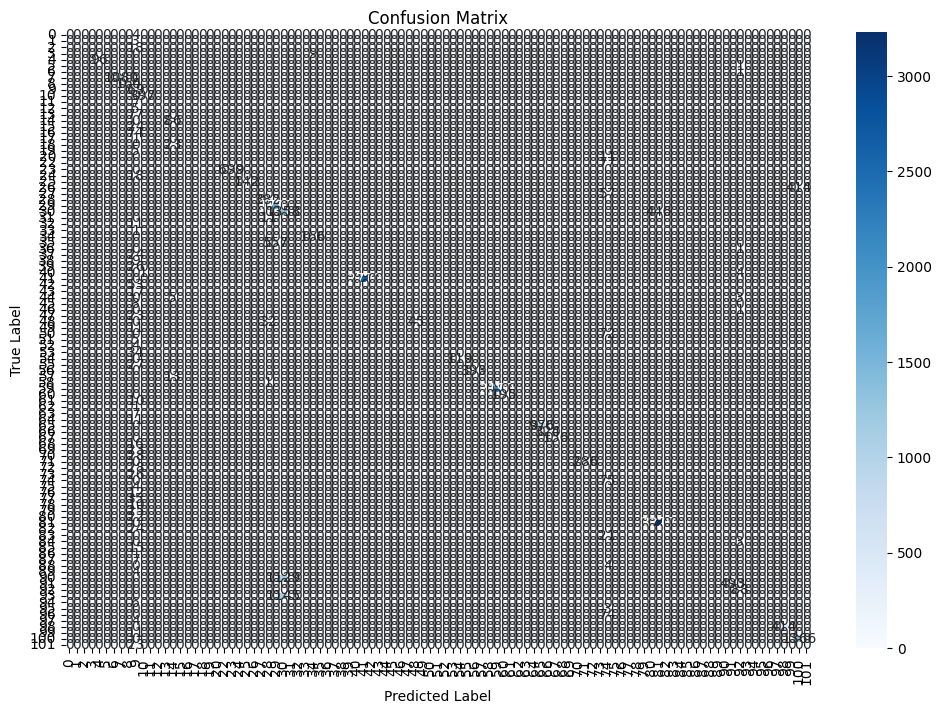

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions
y_pred_probs = model.predict(X_test_final)  # Get probability scores
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class predictions
y_true = np.argmax(y_test_final, axis=1)  # Get actual class labels

# Generate classification report
print(" Classification Report:\n", classification_report(y_true, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [30]:
from tensorflow.keras.models import load_model

# Load the previously trained LSTM model
model = load_model("../data/models/lstm_model.h5")

print(" Saved LSTM Model Loaded Successfully!")

 Saved LSTM Model Loaded Successfully!


In [32]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the tokenizer used during training
with open("../data/models/tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

# Example new transaction descriptions
new_transactions = [
    "Starbucks coffee purchase",
    "Monthly rent payment",
    "Uber ride home",
    "Grocery shopping at Walmart",
    "Netflix subscription renewal"
]

# Convert text to sequences
new_sequences = tokenizer.texts_to_sequences(new_transactions)

# Pad sequences to match training length
new_padded = pad_sequences(new_sequences, maxlen=50, padding="post")

print(" New Transactions Processed Successfully!")

 New Transactions Processed Successfully!


In [33]:
# Predict probabilities for each class
predictions = model.predict(new_padded)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

print("Predicted Classes:", predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Classes: [100  98  29  81  14]


In [43]:
import pandas as pd

# Load category mapping (Assuming you have a CSV with category mappings)
category_mapping = pd.read_csv("../data/processed_data/processed_data.csv")

# Convert label IDs to category names
predicted_categories = [category_mapping.iloc[label]["mcc_category"] for label in predicted_classes]

# Display results
for transaction, category in zip(new_transactions, predicted_categories):
    print(f"Transaction: '{transaction}' → Predicted Category: {category}")

Transaction: 'Starbucks coffee purchase' → Predicted Category: Local and Suburban Commuter Transportation
Transaction: 'Monthly rent payment' → Predicted Category: Service Stations
Transaction: 'Uber ride home' → Predicted Category: Service Stations
Transaction: 'Grocery shopping at Walmart' → Predicted Category: Service Stations
Transaction: 'Netflix subscription renewal' → Predicted Category: Grocery Stores, Supermarkets
